# Алгоритмы интеллектуальной обработки больших объемов данных
## Домашнее задание №2 - Алгоритмы кластеризации


###### <hr\>
**Общая информация**

**Срок сдачи:** 23 октября 2017, 06:00 <br\>
**Штраф за опоздание:** -2 балла после 06:00 23 октября, -4 балла после 06:00 30 октября, -6 баллов после 06:00 6 ноября

При отправлении ДЗ указывайте фамилию в названии файла
Присылать ДЗ необходимо в виде ссылки на свой github репозиторий в slack @alkhamush Необходимо в slack создать таск в приватный чат:
/todo Фамилия Имя ссылка на гитхаб @alkhamush
Пример:
/todo Ксения Стройкова https://github.com/stroykova/spheremailru/stroykova_hw1.ipynb @alkhamush

Используйте данный Ipython Notebook при оформлении домашнего задания.
<hr\>

###### Задание 1 (4 балла)
Реализовать алгоритм кластеризации, который относится к вашему варианту. Проверить работоспособность алгоритма на "Iris". Сравните свой алгоритм кластеризации с алгоритмом из scikit-learn по времени выполнения, использую timeit. Ваша реализация не должна работать сильно дольше, а в идеале должна быть даже немного быстрее.

###### Задание 2 (2 балла)
Выбрать, имплементировать и использовать критерий качества

###### Задание 3 (3балла)
Применить алгоритм кластеризации к данным по странам.   
Подход следующий: фиксируем год, для каждой страны берём индикаторы по зафиксированному году, кластеризуем по индикаторам.   
Разбиение должно быть объяснимым, в противном случае, скорее всего нужно лучше настроить параметры кластеризации.   
Данные нужно скачать тут https://data.worldbank.org/data-catalog/world-development-indicators.   
Также необходимо показать, какие страны попали в общий кластер.
изуализировать результат с помощью T-SNE. Внимание! На полном объеме данных данный алгоритм может работать существенное время.

###### Задание 4 (1 балл)
Опишите в выводе почему и какие страны попали в общий кластер.

Основная задача этого задания - реализация одного из алгоритмов кластеризации. Кроме того, мы научимся подбирать параметры алгоритма, визуализируем результат кластеризации и попытаемся проанализировать природу полученных кластеров.

In [1]:
from itertools import count

import pandas as pd
import pylab as pl
import numpy as np
import scipy.spatial as ss
import sklearn.cluster as sc
import sklearn.manifold as sm
import sklearn.datasets as ds
import sklearn.metrics as smt

import matplotlib.pyplot as plt
import mpl_toolkits.basemap as bm

%matplotlib inline

plt.style.use('ggplot')
plt.rcParams['figure.figsize'] = (12,5)

# Plotting config
%pylab inline

Populating the interactive namespace from numpy and matplotlib


## Реализация алгоритма

Алгоритм кластеризации, который необходимо реализовать, выбирается на основании Вашего порядкового номера в списке группы.

In [2]:
N = 33 # put your index here

In [3]:
algorithms = [
    u"Gaussian Mixture Model с использованием maximum a-posteriori для выбора кластера (параметр - k)",
    u"Hierarchical clustering с поддержкой single-linkage, complete-linkage, average-linkage (параметры - k, linkage)",
    u"DBSCAN. (параметры - epsilon, min_pts)"
]

my_algorithm = algorithms[N % len(algorithms)]
print(u"Реализуем алгоритм кластеризации '%s'" % my_algorithm)

Реализуем алгоритм кластеризации 'Gaussian Mixture Model с использованием maximum a-posteriori для выбора кластера (параметр - k)'


In [4]:
## Задание 1
from sklearn.base import BaseEstimator, ClusterMixin

def norm_distance(X, mu, sigma):
    # print(sigma)
    inv_sigma = np.linalg.pinv(sigma)
    result = np.tensordot(X - mu, inv_sigma, axes=[[1], [0]])
    return np.sum(result * (X - mu), axis=1)
    

def norm_loss(X, mu, sigma):
    d = X.shape[1]
    distance = norm_distance(X, mu, sigma)
    sign, logdet = np.linalg.slogdet(sigma)
    return -distance - logdet
    
def softmax(a):
    a = np.array(a)
    a -= a.max(axis=0)
    a = np.exp(a)
    a /= np.sum(a, axis=0)[np.newaxis, :]
    return a

def norm_loglihood(X, mu, sigma, pi):
    return np.array([norm_loss(X, _mu, _sigma) * _pi for _mu, _sigma, _pi in zip(mu, sigma, pi)])

class Clustering(BaseEstimator, ClusterMixin):
    """
    Implement clustering algorithm according
    """
    
    def __init__(self, k, random_state=None, eps=1e-2):
        """
        Please add necessary algoritm parameters to class constructor.
        """
        self.k = k
        self.random_state = random_state
        self.eps = eps
        self.checkpoint = None
        self.mean = None
        self.std = None
        return
    
    def init_params(self, X):
        self.mu = [X[np.random.randint(0, X.shape[0])]]
        for i in range(1, self.k):
            cumsum = np.cumsum(ss.distance.cdist(X, self.mu, metric='sqeuclidean').min(axis=1))
            index = (cumsum >= np.random.random() * cumsum[-1]).tolist().index(True)
            self.mu.append(X[index])
            
        self.mu = np.array(self.mu)
        self.pi = np.ones(self.k) / self.k
        
        X_minus_mu = X[np.newaxis, :, :] - self.mu[:, np.newaxis, :]
        self.sigma = X_minus_mu[:, :, np.newaxis, :] * X_minus_mu[:, :, :, np.newaxis]
        self.sigma = self.sigma.mean(axis=1)
        
        return self
        
    def fit(self, X, y=None):
        """
        Use data matrix x to compute model parameters
        """
        # X = np.array(X)
        # print(X.shape)
        # X = np.unique(X, axis=0)
        # print(X.shape)
        self.mean = X.mean(axis=0)
        X -= self.mean
        self.std = X.std(axis=0)
        X /= self.std
        # print(X.std(axis=0))
        
        
        np.random.seed(self.random_state)
        self.init_params(X)
        
        for step in count(1):
            self.make_checkpoint()
            
            # E
            aposteriori = softmax(norm_loglihood(X, self.mu, self.sigma, self.pi)).T
            # print(aposteriori)
            # M
            N = np.sum(aposteriori, axis=0)
            self.mu = np.sum(aposteriori[:, :, np.newaxis] * X[:, np.newaxis, :], axis=0)
            self.mu /= N[:, np.newaxis]

            self.sigma = X[np.newaxis] - self.mu[:, np.newaxis, :]
            self.sigma *= aposteriori.T[:, :, np.newaxis]
            self.sigma = np.array([np.tensordot(self.sigma[i], X - self.mu[i], axes=[[0], [0]])
                                   for i in range(self.k)])
            self.sigma /= N[:, np.newaxis, np.newaxis]
            
            """
            for sigma in self.sigma:
                # print(sigma)
                print(np.log(np.abs(np.linalg.det(sigma))))
                if np.log(np.abs(np.linalg.det(sigma))) <= -10:
                    print("Det sigma = 0, step", step)
                    self.restore_checkpoint()
                    return self
            """

            self.pi = N / N.sum()
            
            loss = self.loss(X)
            
            if step < 4:
                pass
            elif prev_loss < loss - self.eps:
                # print("Grouth loss, step", step)

                self.restore_checkpoint()
                return self
            elif prev_loss <= loss + self.eps:
                break
            
            prev_loss = loss
        
        return self
    
    def predict(self, X):
        """
        Using computed model parameters predict cluster
        for all objects from x
        """
        X = X.copy()
        X -= self.mean
        X *= self.std
        dzeta = norm_loglihood(X, self.mu, self.sigma, self.pi)
        return np.argmax(dzeta, axis=0)
    
    def fit_predict(self, x, y=None):
        self.fit(x, y)
        return self.predict(x)
    
    def loss(self, X, y=None):
        
        # result = norm_distance(X, self.mu, self.sigma, self.pi)
        result = np.array([norm_distance(X, mu, sigma) for mu, sigma in zip(self.mu, self.sigma)])
        return -result[:, result.argmin(axis=0)].sum()
        return (((X - self.mu[self.predict(X)]) / X.std(axis=0)[np.newaxis]) ** 2).sum(axis=1).mean()
        return norm_loglihood(X, self.mu, self.sigma, self.pi).sum() 
    
    def make_checkpoint(self):
        self.checkpoint = self.mu, self.sigma, self.pi
    
    def restore_checkpoint(self):
        self.mu, self.sigma, self.pi = self.checkpoint

Алгоритм кластеризации должен удовлетворять следующему интерфейсу. Конструктор принимает набор параметров, необходимых для работы алгоритма кластеризации. Метод `fit` подсчитывает параметры модели и возвращает `self`. Метод `predict` возвращает вектор с индексами кластеров для поданных в него объектов `x`

Сначала проверим реализованный алгоритм кластеризации на классическом наборе данных [Iris](http://www.wikiwand.com/en/Iris_flower_data_set). Загрузим данные (они включены в библиотеку sklearn) и посмотрим на то, как они выглядят в двух проекциях (для простоты используем 2 класса из 3).

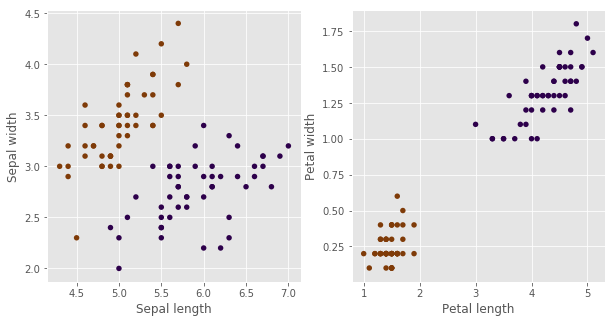

In [5]:
iris = ds.load_iris()
x_iris = iris.data[:100]
y_iris = iris.target[:100]

pl.figure(figsize=(10, 5))

pl.subplot(1, 2, 1)
pl.scatter(x_iris[:, 0], x_iris[:, 1], c=y_iris, cmap=pl.cm.PuOr, lw=0, s=30)
plt.xlabel('Sepal length')
plt.ylabel('Sepal width')

pl.subplot(1, 2, 2)
pl.scatter(x_iris[:, 2], x_iris[:, 3], c=y_iris, cmap=pl.cm.PuOr, lw=0, s=30)
plt.xlabel('Petal length')
plt.ylabel('Petal width')
pl.show()

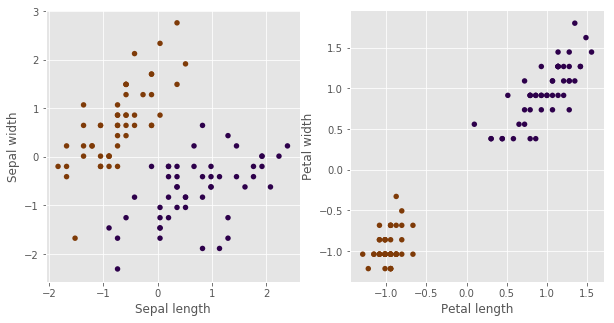

Adjusted Rand index for iris is: 1.00


In [15]:
pred_iris = Clustering(k=2, random_state=2).fit_predict(x_iris)

pl.figure(figsize=(10, 5))

pl.subplot(1, 2, 1)
pl.scatter(x_iris[:, 0], x_iris[:, 1], c=pred_iris, cmap=pl.cm.PuOr, lw=0, s=30)
plt.xlabel('Sepal length')
plt.ylabel('Sepal width')

pl.subplot(1, 2, 2)
pl.scatter(x_iris[:, 2], x_iris[:, 3], c=pred_iris, cmap=pl.cm.PuOr, lw=0, s=30)
plt.xlabel('Petal length')
plt.ylabel('Petal width')
pl.show()

print("Adjusted Rand index for iris is: %.2f" % smt.adjusted_rand_score(y_iris, pred_iris))

In [7]:
import timeit
from sklearn.mixture import GaussianMixture

print("My implementation:", timeit.timeit("Clustering(k=2).fit_predict(x_iris)", number=100, globals={"Clustering": Clustering, "x_iris": x_iris}))
print("Scikit-learn implementation:", timeit.timeit("Clustering(n_components=2).fit(x_iris).predict(x_iris)", number=100, globals={"Clustering": GaussianMixture, "x_iris": x_iris}))

My implementation: 3.5163860489992658
Scikit-learn implementation: 0.9926174679967517


Видно, что классы разделяются, поэтому можно надеяться, что наш алгоритм "найдет" кластеры, соответствующие исходным классам. Результат работы реализованного алгоритма кластеризации предлагается сравнить с эталонной кластеризацией. Для этого предлагается изучить метрику ([adjusted rand score](http://scikit-learn.org/stable/modules/generated/sklearn.metrics.adjusted_rand_score.html)). В случае если значение этой метрики отличается от 1, предлагается поработать над улучшением реализации своего алгоритма.

Выбрать и реализовать критерий качества, на основании которого будут подбираться параметры модели. Варианты критериев:
- Инерция (сумма квадратов расстояний от каждой из точек до ближайшего к этой точке центроида)
- Средний диаметр (максимальное расстояние между точками в кластере) или радиус (расстояние от центроида до самой дальней от него точки в кластере)
- Sihouette

**Критерий качества необходимо выбрать таким образом, чтобы он подходил для реализованного алгоритма**

In [8]:
## Задание 2
def inertion(X, y):
    """
    Implement quality criterion of your choice
    """
    loss = 0
    X = np.array(X)
    X -= X.mean(axis=0)
    X /= X.std(axis=0)
    for label in range(y.max() + 1):
        cluster = X[y == label]
        if cluster.shape[0] > 0:
            # print(cluster - cluster.mean(axis=0))
            loss += ((cluster - cluster.mean(axis=0)) ** 2).mean()
    return loss

Применим критерий для выбора параметров алгоритма. Предлагается изменить следующий код таким образом, чтобы кластеризация вызывалась с верным набором параметров. На графике можно будет увидеть зависимость критерия от параметров алгоритма. Необходимо выбрать оптимальные значения этих параметров.

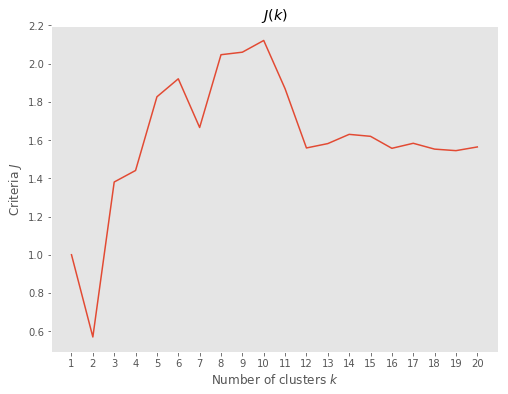

In [9]:
ks = range(1, 21)
criteria = np.zeros(len(ks))

for i, k in enumerate(ks):
    criteria[i] = +inf
    for random_state in range(10):
        cls = Clustering(k, random_state=random_state)
        y = cls.fit_predict(x_iris)
        criteria[i] = min(inertion(x_iris, y), criteria[i])
    
pl.figure(figsize=(8, 6))
pl.plot(ks, criteria)
pl.title("$J(k)$")
pl.ylabel("Criteria $J$")
pl.xlabel("Number of clusters $k$")
pl.xticks(ks)
pl.grid()
pl.show()

In [10]:
## Задание 3
countries = pd.read_csv("WDIData.csv")
data = countries.pivot_table(values="2010", index=["Country Name"], columns=["Indicator Name"])
data = data.fillna(data.median())
data = data.loc[:, data.std() > 0]
X_countries = data.values
countries_labels = data.index.values

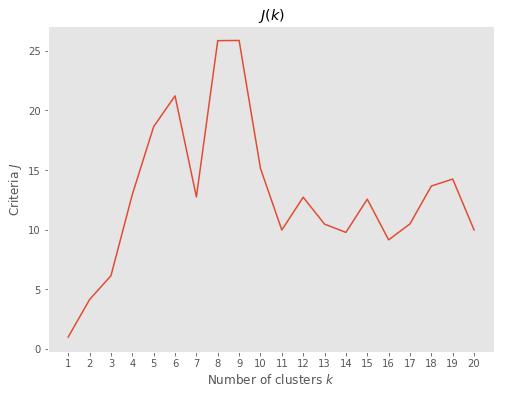

In [11]:
from sklearn.feature_selection import VarianceThreshold
from sklearn.decomposition import PCA

ks = range(2, 21)
criteria = np.zeros(len(ks))

np.random.seed(45)

X_countries = data.values
X_countries = PCA(n_components=10).fit_transform(X_countries)

ks = range(1, 21)
criteria = np.zeros(len(ks))

for i, k in enumerate(ks):
    criteria[i] = +inf
    for random_state in range(10):
        cls = Clustering(k, random_state=random_state)
        y = cls.fit_predict(X_countries)
        criteria[i] = min(inertion(X_countries, y), criteria[i])
    
pl.figure(figsize=(8, 6))
pl.plot(ks, criteria)
pl.title("$J(k)$")
pl.ylabel("Criteria $J$")
pl.xlabel("Number of clusters $k$")
pl.xticks(ks)
pl.grid()
pl.show()

In [12]:
best_criteria = +inf
for random_state in range(10):
    cls = Clustering(k=7, random_state=random_state)
    y = cls.fit_predict(X_countries)
    criteria = inertion(X_countries, y)
    if criteria < best_criteria:
        best_criteria = criteria
        data.loc[:, "Cluster index"] = y

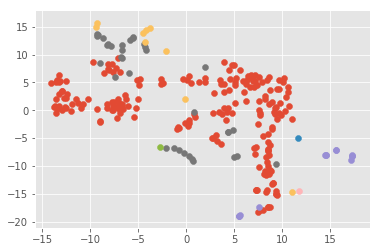

In [13]:
from sklearn.manifold import TSNE

coords = TSNE(n_components=2, init='pca', random_state=0).fit_transform(X_countries)

for i in range(7):
    _c = coords[data["Cluster index"].values == i]
    plt.scatter(_c[:, 0], _c[:, 1])

In [14]:
for group, elems in data.groupby("Cluster index"):
    print(group)
    print(*elems.index, sep="\n") # .loc[:, "Country Name"])
    print("======")

0
Afghanistan
Albania
American Samoa
Andorra
Antigua and Barbuda
Arab World
Argentina
Armenia
Aruba
Australia
Austria
Azerbaijan
Bahamas, The
Bahrain
Barbados
Belarus
Belgium
Belize
Benin
Bermuda
Bhutan
Bolivia
Bosnia and Herzegovina
Botswana
British Virgin Islands
Brunei Darussalam
Bulgaria
Burkina Faso
Burundi
Cabo Verde
Canada
Caribbean small states
Cayman Islands
Central African Republic
Central Europe and the Baltics
Channel Islands
Comoros
Croatia
Cuba
Curacao
Cyprus
Czech Republic
Denmark
Djibouti
Dominica
Dominican Republic
Early-demographic dividend
East Asia & Pacific (IDA & IBRD countries)
East Asia & Pacific (excluding high income)
Ecuador
Egypt, Arab Rep.
El Salvador
Eritrea
Estonia
Ethiopia
Europe & Central Asia (IDA & IBRD countries)
Europe & Central Asia (excluding high income)
Faroe Islands
Fiji
Finland
Fragile and conflict affected situations
France
French Polynesia
Gambia, The
Georgia
Germany
Ghana
Gibraltar
Greece
Greenland
Grenada
Guam
Guatemala
Guinea-Bissau
Guyan

## Задание 4

Страны разделились на следующие кластеры:
    
1. Более развитые страны.
2. Класс-выброс.
3. Усредненные значения по странам.
4. Медленно развивающиеся страны.
5. Очень быстро развивающиеся страны.
6. Класс-выброс.
7. Класс-выброс.

Поздравляем, Вы завершили домашние задания по модулю "Алгоритмы кластеризации". Надеемся, что это было интересно.